# Load packages

In [1]:
from ast import literal_eval
import math
import numpy as np
import altair as alt
import pandas as pd
import shapely as shp
import geopandas as gpd
from datetime import timedelta, time
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.widgets import Button, Slider, CheckButtons

import itertools
from dijkstar import Graph, find_path

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np

from helper_functions import open_processed_gtfs, open_delays, open_stations

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

# Notebook settings

In [2]:
RESULTS_TOTAL_FILEPATH = r'Second model results\forward_total.csv'
RESULTS_WEEKDAYS_FILEPATH = r'Second model results\forward_weekday'
DELAYS_FILEPATH = r'Intermediates\\delays_assigned.csv'
LINKS_FILEPATH = r'Intermediates\\GTFS_20190914\\gtfs_links_corrected.geojson'
STATIONS_FILEPATH = r'Intermediates\\GTFS_20190914\\gtfs_stations_corrected.geojson'

# RESULTS_TOTAL_FILEPATH = r'Second model results\forward_weekday_0.csv'

DISTRIBUTION = stats.exponnorm
DISTRIBUTION_NAME = 'exponnorm'
PERCENTILE = 95

RESULTS_TOTAL_FILEPATH = f"{RESULTS_TOTAL_FILEPATH[:-4]}_{DISTRIBUTION_NAME}.csv"

TITLES = ['Lower bound of the 95% confidence interval', 'Mean', 'Upper bound of the 95% confidence interval']
NON_EXISTENT_CONNECTIONS = [('C05', 'C07'), ('B01/F01', 'E02'), ('E01', 'F02')] # Both directions
END_OF_LINE_CONNECTIONS = [('A15', 'A14'), ('B11', 'B10'), ('C15', 'C14'), ('D13', 'D12'), ('E10', 'E09'), ('F11', 'F10'), ('G05', 'G04'), ('J03', 'J02'), ('K08', 'K07'), ('N06', 'N04')] # Both directions?

def filter_out_connections(stop_pair):
    if stop_pair in NON_EXISTENT_CONNECTIONS or (stop_pair[1], stop_pair[0]) in NON_EXISTENT_CONNECTIONS:
        return True
    if stop_pair in END_OF_LINE_CONNECTIONS or (stop_pair[1], stop_pair[0]) in END_OF_LINE_CONNECTIONS:
        return True
    return False
FULLY_FILTERED = True

# Load and prepare data

In [3]:
forward_result_total = pd.read_csv(RESULTS_TOTAL_FILEPATH)
forward_result_total['dist_params'] = [literal_eval(dist_params) for dist_params in forward_result_total['dist_params'].values]
if 'Unnamed: 0' in forward_result_total.columns:
    forward_result_total = forward_result_total.drop(columns=['Unnamed: 0'])
forward_result_total.head(5)

,timestep,from_stop,to_stop,dist_params
0,5.0,A01/C01,A02,"[1.6932084843842516, -46.61632500463405, 10.47..."
1,6.0,A01/C01,A02,"[1.4724190201183482, -43.87800761255711, 11.90..."
2,7.0,A01/C01,A02,"[1.4121326845647255, -38.864132458264876, 12.0..."
3,8.0,A01/C01,A02,"[1.2850950019381768, -33.17069368712228, 13.88..."
4,9.0,A01/C01,A02,"[1.9929803709128393, -38.393698881037736, 10.6..."


In [4]:
# Get means highs lows
means = []
highs = []
lows = []

high_percentile = ((PERCENTILE / 2) + 50) / 100
low_percentile = (50 - (PERCENTILE / 2)) / 100

for index, result in forward_result_total.iterrows():
    # print(index)
    dist_params = result['dist_params']

    means.append(DISTRIBUTION.mean(*dist_params))
    highs.append(DISTRIBUTION.ppf(high_percentile, *dist_params))
    lows.append(DISTRIBUTION.ppf(low_percentile, *dist_params))

forward_result_total['mean'] = means
forward_result_total['high'] = highs
forward_result_total['low'] = lows

In [5]:
gtfs_stations = open_stations(STATIONS_FILEPATH)
gtfs_stations.head(5)

,stop_id,stop_name,connections,geometry
0,E02,SHAW METRO STATION,"[[E03, E01], [E01, E03]]",POINT (1306094.353 454461.868)
1,D11,CHEVERLY METRO STATION,"[[D10, D12], [D12, D10]]",POINT (1336488.46 455202.936)
2,G02,CAPITOL HEIGHTS METRO STATION,"[[G01, G03], [G03, G01]]",POINT (1337007.377 445376.966)
3,E03,U STREET METRO STATION,"[[E04, E02], [E02, E04]]",POINT (1304034.044 455361.654)
4,D12,LANDOVER METRO STATION,"[[D11, D13], [D13, D11]]",POINT (1343622.123 461562.939)


In [6]:
links = gpd.read_file(LINKS_FILEPATH)
print(f"Amount of network connections: {len(links):_}")
links.head(3)

Amount of network connections: 189


,link_id,from_stop,to_stop,travel_time,geometry
0,A15_to_A14,A15,A14,240,"LINESTRING (-77.16476 39.11999, -77.14669 39.0..."
1,A14_to_A13,A14,A13,180,"LINESTRING (-77.14669 39.08545, -77.12079 39.0..."
2,A13_to_A12,A13,A12,180,"LINESTRING (-77.12079 39.06239, -77.11278 39.0..."


In [7]:
delays = open_delays(DELAYS_FILEPATH)
delays.head(3)

Amount of delay values: 3_802_649


,line_name,trip_id,shape_id,stop,sched_arrival_time,previous_stop,next_stop,real_arrival_time,delay,timestep
0,BLUE,3121350_18154_2019-09-14,46,G05,2019-09-14 06:54:00,NaN,G04,2019-09-14 06:46:04,-476.0,6.0
1,BLUE,3121350_18154_2019-09-14,46,G04,2019-09-14 06:57:00,G05,G03,2019-09-14 06:56:12,-48.0,6.0
2,GREEN,3120258_18154_2019-09-14,117,F11,2019-09-14 07:00:00,NaN,F10,2019-09-14 06:45:42,-858.0,7.0


In [8]:
inplace_functions = pd.read_csv(r'Intermediates\inplace_function_params.csv')

for index, entry in inplace_functions.iterrows():
    for column in ['dist_params']:
        params_value = entry[column]
        if isinstance(params_value, str):
            params_string = params_value[1:-1]
            params_split = params_string.split(', ')
            params_tuple = tuple([float(param) for param in params_split])

            inplace_functions.at[index, column] = params_tuple

if 'own_dist_params' in inplace_functions.columns:
    inplace_functions = inplace_functions.drop(columns=['own_dist_params'])

inplace_functions.head(3)

,timestep,stop,direction,avg_sched_time_diff,dist_params
0,5.0,A08,A07,480.0,"(34268260.19331414, 69.99997693018886, 153.440..."
1,5.0,A08,A09,420.0,"(12521509.98876049, 106.99988040443998, 302.67..."
2,5.0,A09,A08,480.0,"(22513538.175658442, 107.9999641838561, 148.77..."


# Get connection avgs dict

In [9]:
connection_avgs = {}
results_connection_split = {connection: connection_funcs for connection, connection_funcs in forward_result_total.groupby(['from_stop', 'to_stop'])}
for connection, connection_funcs in results_connection_split.items():
    connection_avgs[connection] = {}

    connection_avgs[connection]['low'] = np.mean(connection_funcs['low'].values)
    connection_avgs[connection]['mean'] = np.mean(connection_funcs['mean'].values)
    connection_avgs[connection]['high'] = np.mean(connection_funcs['high'].values)

# Make variable examinations plots

## Boxplot per line

In [10]:
# Number of lines travelling across each link
# Time between trains on each link

line_stations_pairs = [index for index, _ in delays.groupby(['line_name', 'stop', 'next_stop'])]
lines = delays['line_name'].unique().tolist()
lines

['BLUE', 'GREEN', 'RED', 'ORANGE', 'SILVER', 'YELLOW']

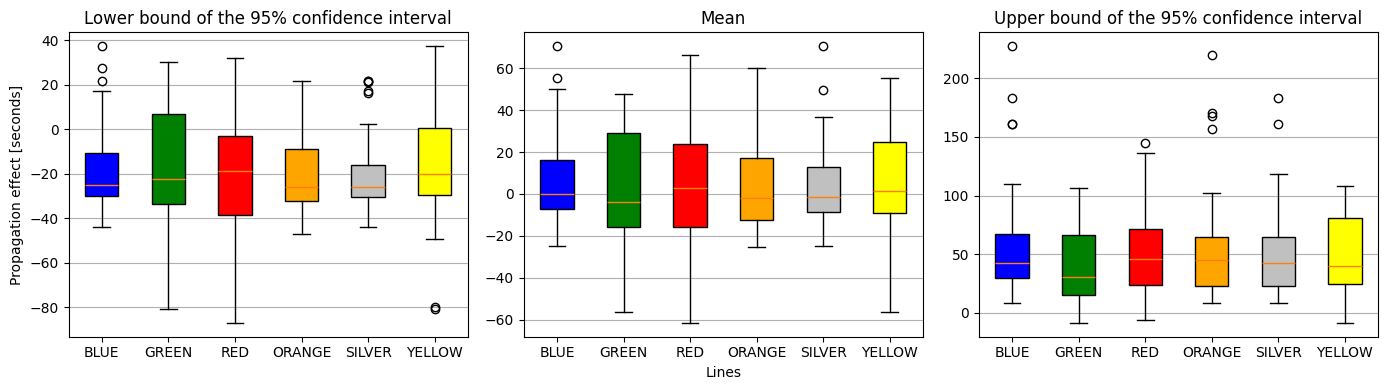

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

for value_type, ax, title in zip(['low', 'mean', 'high'], (ax1, ax2, ax3), TITLES):
    lines_data = {line: [] for line in lines}
    for line_station_pair in line_stations_pairs:
        line, stop, next_stop = line_station_pair

        if filter_out_connections((stop, next_stop)):
            continue

        if (stop, next_stop) in connection_avgs:
            lines_data[line].append(connection_avgs[(stop, next_stop)][value_type])

        # connection_functions = forward_result_total[(forward_result_total['from_stop'] == stop) & \
        #                                         (forward_result_total['to_stop'] == next_stop)]

        # lines_data[line].extend(connection_functions[value_type].values)

    labels = list(lines_data.keys())
    colors = [label.lower() for label in labels]
    data = list(lines_data.values())

    bplot = ax.boxplot(data,
                      patch_artist=True,  # fill with color
                     tick_labels=labels)  # will be used to label x-ticks

    # fill with colors
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    if ax == ax1:
        ax.set_ylabel('Propagation effect [seconds]')
    if ax == ax2:
        ax.set_xlabel('Lines')
    ax.set_title(title)
    ax.grid(axis='y')

plt.tight_layout()

if FULLY_FILTERED:
    plt.savefig(r'Codebase figures\boxplot_per_line_filtered.png', dpi=200)
else:
    plt.savefig(r'Codebase figures\boxplot_per_line.png', dpi=200)

## ROUTES

In [12]:
blue_route = ['J03', 'J02', 'C13', 'C12', 'C10', 'C09', 'C08', 'C07', 'C06', 'C05', 'C04', 'C03', 'C02', 'A01/C01', 'D01', 'D02', 'D03/F03', 'D04', 'D05', 'D06', 'D07', 'D08', 'G01', 'G02', 'G04', 'G05']
orange_route = ['K08', 'K07', 'K06', 'K05', 'K04', 'K03', 'K02', 'K01', 'C05', 'C04', 'C03', 'C02', 'A01/C01', 'D01', 'D02', 'D03/F03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'D11', 'D12', 'D13']
silver_route = ['N06', 'N04', 'N03', 'N02', 'N01', 'K05', 'K04', 'K03', 'K02', 'K01', 'C05', 'C04', 'C03', 'C02', 'A01/C01', 'D01', 'D02', 'D03/F03', 'D04', 'D05', 'D06', 'D07', 'D08', 'G01', 'G02', 'G03', 'G04', 'G05']
red_route = ['A15', 'A14', 'A13', 'A12', 'A11', 'A10', 'A09', 'A08', 'A07', 'A06', 'A05', 'A04', 'A03', 'A02', 'A01/C01', 'B01/F01', 'B02', 'B03', 'B04', 'B05', 'B06/E06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B35']
yellow_route = ['C15', 'C14', 'C13', 'C12', 'C10', 'C09', 'C08', 'C07', 'D03/F03', 'F02', 'B01/F01', 'E01']
green_route = ['F11', 'F10', 'F08', 'F07', 'F06', 'F05', 'F04', 'D03/F03', 'F02', 'B01/F01', 'E01', 'E02', 'E03', 'E04', 'E05', 'E07', 'E08', 'E09', 'E10']
routes = [blue_route, orange_route, silver_route, red_route, yellow_route, green_route]

## Boxplot per line per direction

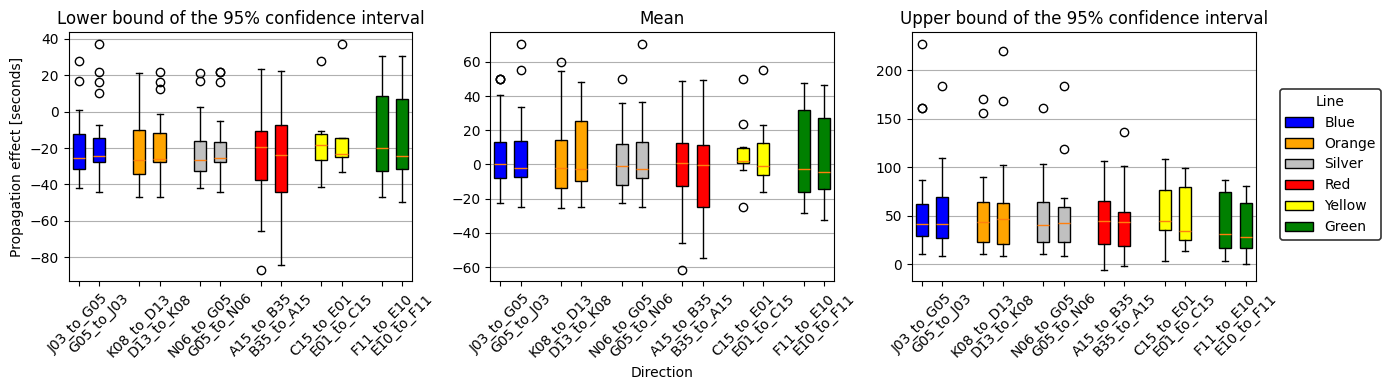

In [13]:
routes = [blue_route, orange_route, silver_route, red_route, yellow_route, green_route]
labels = ['Blue', 'Orange', 'Silver', 'Red', 'Yellow', 'Green']
colors = ['blue', 'orange', 'silver', 'red', 'yellow', 'green']


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

for value_type, ax, title in zip(['low', 'mean', 'high'], (ax1, ax2, ax3), TITLES):
    data_dict = {}
    for route, label in zip(routes, labels):
        data_dict[label] = {}

        data_dict[label][f"{route[0]}_to_{route[-1]}"] = []
        for stop, next_stop in zip(route[:-1], route[1:]):
            # connection_functions = forward_functions[(forward_functions['from_stop'] == stop) & \
                                                    # (forward_functions['to_stop'] == next_stop)]

            # data_dict[label][f"{route[0]}_to_{route[-1]}"].extend(connection_functions['mean'].values)
            if filter_out_connections((stop, next_stop)):
                continue

            if (stop, next_stop) in connection_avgs:
                data_dict[label][f"{route[0]}_to_{route[-1]}"].append(connection_avgs[(stop, next_stop)][value_type])



        reverse_route = route[::-1]
        data_dict[label][f"{reverse_route[0]}_to_{reverse_route[-1]}"] = []
        for stop, next_stop in zip(reverse_route[:-1], reverse_route[1:]):
            # connection_functions = forward_functions[(forward_functions['from_stop'] == stop) & \
            #                                         (forward_functions['to_stop'] == next_stop)]
            if filter_out_connections((stop, next_stop)):
                continue

            if (stop, next_stop) in connection_avgs:
                data_dict[label][f"{reverse_route[0]}_to_{reverse_route[-1]}"].append(connection_avgs[(stop, next_stop)][value_type])

            # data_dict[label][f"{reverse_route[0]}_to_{reverse_route[-1]}"].extend(connection_functions['mean'].values)

    box_position = 1
    x_tick_labels = []
    x_tick_positions = []
    for (line, line_data), color in zip(data_dict.items(), colors):

        add_label = True
        for (direction, direction_data) in line_data.items():
            boxplot = ax.boxplot(direction_data, positions=[box_position], widths=0.6, patch_artist=True, label=line if add_label else "")
            add_label = False

            x_tick_labels.append(direction)
            x_tick_positions.append(box_position)
            box_position += 1

            for patch in boxplot['boxes']:
                patch.set_facecolor(color)
                # patch.set_alpha(0.8)
        
        box_position += 1  # space between lines

    ax.set_xticklabels(x_tick_labels, rotation=45)
    ax.set_xticks(x_tick_positions)

    if ax == ax1:
        ax.set_ylabel('Propagation effect [seconds]')
    if ax == ax2:
        ax.set_xlabel('Direction')
    if ax == ax3:
        legend = ax.legend(bbox_to_anchor=(1.05, 0.8),  ncol=1, title="Line")
        legend.get_frame().set_edgecolor('black')
        legend.get_frame().set_linewidth(1.2)
    ax.set_title(title)
    ax.grid(axis='y')

plt.tight_layout()

if FULLY_FILTERED:
    plt.savefig(r'Codebase figures\boxplot_per_line_per_direction_filtered.png', dpi=200)
else:
    plt.savefig(r'Codebase figures\boxplot_per_line_per_direction.png', dpi=200)

## Boxplot per hour per line

In [14]:
# labels = ['Blue', 'Orange', 'Silver', 'Red', 'Yellow', 'Green']
# colors = ['blue', 'orange', 'silver', 'red', 'yellow', 'green']


# timesteps = forward_functions['timestep'].unique().tolist()
# timesteps.sort()

# data_dict = {}
# for timestep in timesteps:
#     data_dict[timestep] = {}

#     for route, label in zip(routes, labels):
#         data_dict[timestep][label] = []
#         for stop, next_stop in zip(route[:-1], route[1:]):
#             connection_functions = forward_functions[(forward_functions['from_stop'] == stop) & \
#                                                      (forward_functions['to_stop'] == next_stop) & \
#                                                      (forward_functions['timestep'] == timestep)]
            
#             if len(connection_functions) > 0:
#                 data_dict[timestep][label].append(connection_functions['mean'].values[0])

#         reverse_route = route[::-1]
#         for stop, next_stop in zip(reverse_route[:-1], reverse_route[1:]):
#             connection_functions = forward_functions[(forward_functions['from_stop'] == stop) & \
#                                                      (forward_functions['to_stop'] == next_stop) & \
#                                                      (forward_functions['timestep'] == timestep)]

#             if len(connection_functions) > 0:
#                 data_dict[timestep][label].append(connection_functions['mean'].values[0])


# fig, ax = plt.subplots(figsize=(22, 6))
# box_position = 1
# x_tick_labels = []
# x_tick_positions = []
# for timestep, timestep_data in data_dict.items():
    
#     line_counter = 0
#     for (line, line_data), color in zip(timestep_data.items(), colors): 

#         if timestep == timesteps[0]:
#             boxplot = ax.boxplot(line_data, positions=[box_position], widths=0.8, patch_artist=True, label=line)
#         else:
#             boxplot = ax.boxplot(line_data, positions=[box_position], widths=0.8, patch_artist=True)
        
#         for patch in boxplot['boxes']:
#             patch.set_facecolor(color)
#             # patch.set_alpha(0.8)

#         box_position += 1
#         line_counter += 1

#         if line_counter == 3:
#             x_tick_labels.append(int(timestep))
#             x_tick_positions.append(box_position + 0.5)
    
#     box_position += 1  # space between timesteps

# ax.set_xticks(x_tick_positions)
# ax.set_xticklabels(x_tick_labels, rotation=45)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True);

# ax.set_ylim(-100, 200)


#     # PER DIRECTION?
#     # for route, label in zip(routes, labels):
#     #     data_dict[timestep][label] = {}
#     #     data_dict[timestep][label][f"{route[0]}_to_{route[-1]}"] = []
#     #     for stop, next_stop in zip(route[:-1], route[1:]):
#     #         connection_functions = forward_functions[(forward_functions['from_stop'] == stop) & \
#     #                                                  (forward_functions['to_stop'] == next_stop) & \
#     #                                                  (forward_functions['timestep'] == timestep)]

#     #         data_dict[timestep][label][f"{route[0]}_to_{route[-1]}"].extend(connection_functions['mean'].values)

#     #     reverse_route = route[::-1]
#     #     data_dict[timestep][label][f"{reverse_route[0]}_to_{reverse_route[-1]}"] = []
#     #     for stop, next_stop in zip(reverse_route[:-1], reverse_route[1:]):
#     #         connection_functions = forward_functions[(forward_functions['from_stop'] == stop) & \
#     #                                                  (forward_functions['to_stop'] == next_stop) & \
#     #                                                  (forward_functions['timestep'] == timestep)]

#     #         data_dict[timestep][label][f"{reverse_route[0]}_to_{reverse_route[-1]}"].extend(connection_functions['mean'].values)

# ax.set_title('Mean effect on delays per line per hour')
# ax.set_ylabel('Mean effect on delay [s]')
# ax.set_xlabel('Hour of the day')

## Boxplot per hour per line per direction

In [15]:
# labels = ['Blue', 'Orange', 'Silver', 'Red', 'Yellow', 'Green']
# colors = ['blue', 'orange', 'silver', 'red', 'yellow', 'green']


# timesteps = forward_functions['timestep'].unique().tolist()
# timesteps.sort()

# data_dict = {}
# for timestep in timesteps:
#     data_dict[timestep] = {}


#     for route, label in zip(routes, labels):
#         data_dict[timestep][label] = {}
#         data_dict[timestep][label][f"{route[0]}_to_{route[-1]}"] = []
#         for stop, next_stop in zip(route[:-1], route[1:]):
#             connection_functions = forward_functions[(forward_functions['from_stop'] == stop) & \
#                                                      (forward_functions['to_stop'] == next_stop) & \
#                                                      (forward_functions['timestep'] == timestep)]

#             if len(connection_functions) > 0:
#                 data_dict[timestep][label][f"{route[0]}_to_{route[-1]}"].append(connection_functions['mean'].values[0])

#         reverse_route = route[::-1]
#         data_dict[timestep][label][f"{reverse_route[0]}_to_{reverse_route[-1]}"] = []
#         for stop, next_stop in zip(reverse_route[:-1], reverse_route[1:]):
#             connection_functions = forward_functions[(forward_functions['from_stop'] == stop) & \
#                                                      (forward_functions['to_stop'] == next_stop) & \
#                                                      (forward_functions['timestep'] == timestep)]

#             if len(connection_functions) > 0:
#                 data_dict[timestep][label][f"{reverse_route[0]}_to_{reverse_route[-1]}"].append(connection_functions['mean'].values[0])


# fig, ax = plt.subplots(figsize=(22, 6))
# box_position = 1
# x_tick_labels = []
# x_tick_positions = []
# for timestep, timestep_data in data_dict.items():
    
#     line_counter = 0
#     for (line, line_data), color in zip(timestep_data.items(), colors):

#         add_label = True
#         for direction, direction_data in line_data.items():
#             if timestep == timesteps[0]:
#                 boxplot = ax.boxplot(direction_data, positions=[box_position], widths=0.8, patch_artist=True, label=line if add_label else "")
#                 add_label = False
#             else:
#                 boxplot = ax.boxplot(direction_data, positions=[box_position], widths=0.8, patch_artist=True)
            
#             for patch in boxplot['boxes']:
#                 patch.set_facecolor(color)
#                 # patch.set_alpha(0.8)

#             box_position += 1
#         line_counter += 1

#         if line_counter == 3:
#             x_tick_labels.append(int(timestep))
#             x_tick_positions.append(box_position + 0.5)
    
#     box_position += 1  # space between timesteps

# ax.set_xticks(x_tick_positions)
# ax.set_xticklabels(x_tick_labels, rotation=45)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True);

# ax.set_ylim(-100, 200)
# ax.hlines(0, xmin=1, xmax=box_position-1, colors='red', linestyles='dashed', alpha=0.5)

# ax.set_title('Mean effect on delays per line per direction per hour')
# ax.set_ylabel('Mean effect on delay [s]')
# ax.set_xlabel('Hour of the day')

## Boxplot amount of connection per station

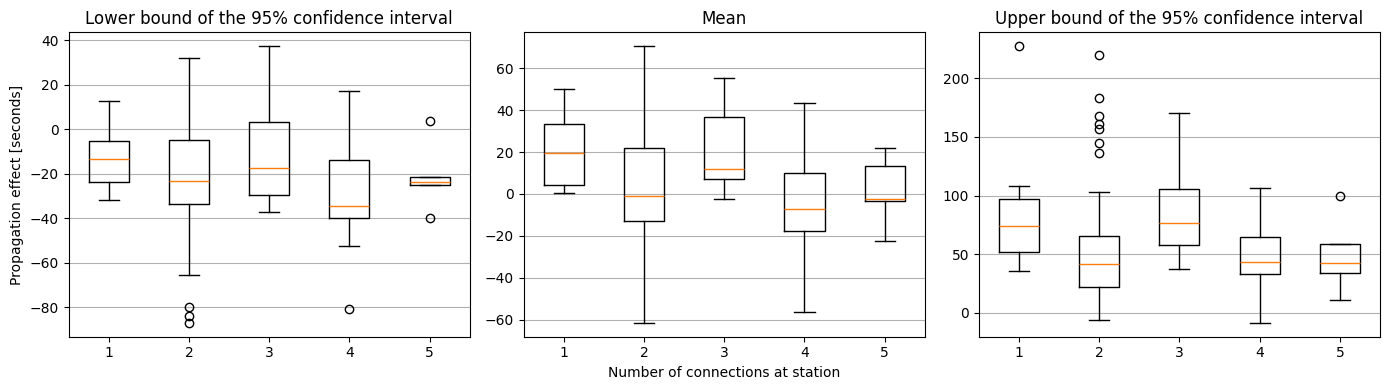

In [16]:
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

for value_type, ax, title in zip(['low', 'mean', 'high'], (ax1, ax2, ax3), TITLES):

    stops = {}

    for connection, avgs in connection_avgs.items():
        if filter_out_connections(connection):
            continue

        if connection[0] not in stops:
            stops[connection[0]] = {'count': 0, 'avgs': []}
        
        stops[connection[0]]['count'] += 1
        stops[connection[0]]['avgs'].append(avgs[value_type])

    data_dict = {1: [], 2: [], 3: [], 4: [], 5: []}
    for stop, stop_data in stops.items():
        data_dict[stop_data['count']].extend(stop_data['avgs'])

    bplot = ax.boxplot(data_dict.values(),
                    tick_labels=data_dict.keys())


    if ax == ax1:
        ax.set_ylabel('Propagation effect [seconds]')
    if ax == ax2:
        ax.set_xlabel('Number of connections at station')
    ax.set_title(title)
    ax.grid(axis='y')

plt.tight_layout()

if FULLY_FILTERED:
    plt.savefig(r'Codebase figures\boxplot_number_of_connections_filtered.png', dpi=200)
else:
    plt.savefig(r'Codebase figures\boxplot_number_of_connections.png', dpi=200)

## Boxplot link by travel time

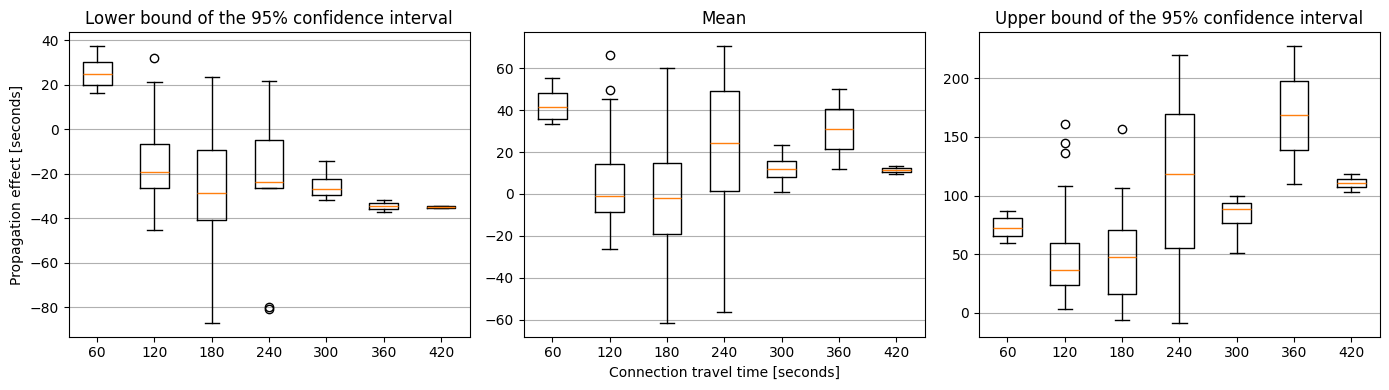

In [17]:
        
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

for value_type, ax, title in zip(['low', 'mean', 'high'], (ax1, ax2, ax3), TITLES):
    ys = []
    xs = []

    for connection, avgs in connection_avgs.items():
        if filter_out_connections(connection):
            continue

        travel_times = links[(links['from_stop'] == connection[0]) & (links['to_stop'] == connection[1])]['travel_time'].values
        if len(travel_times) == 0:
            continue
        xs.append(travel_times[0])
        ys.append(avgs[value_type])

    data_dict = {}
    for x, y in zip(xs, ys):
        if int(x) not in data_dict:
            data_dict[int(x)] = []
        data_dict[int(x)].append(y)
    data_dict = {key:data_dict[key] for key in sorted(data_dict.keys())}

    bplot = ax.boxplot(data_dict.values(),
                       tick_labels=data_dict.keys())

    if ax == ax1:
        ax.set_ylabel('Propagation effect [seconds]')
    if ax == ax2:
        ax.set_xlabel('Connection travel time [seconds]')
    ax.set_title(title)
    ax.grid(axis='y')

plt.tight_layout()

if FULLY_FILTERED:
    plt.savefig(r'Codebase figures\boxplot_travel_time_filtered.png', dpi=200)
else:
    plt.savefig(r'Codebase figures\boxplot_travel_time.png', dpi=200)

## Boxplot per branch

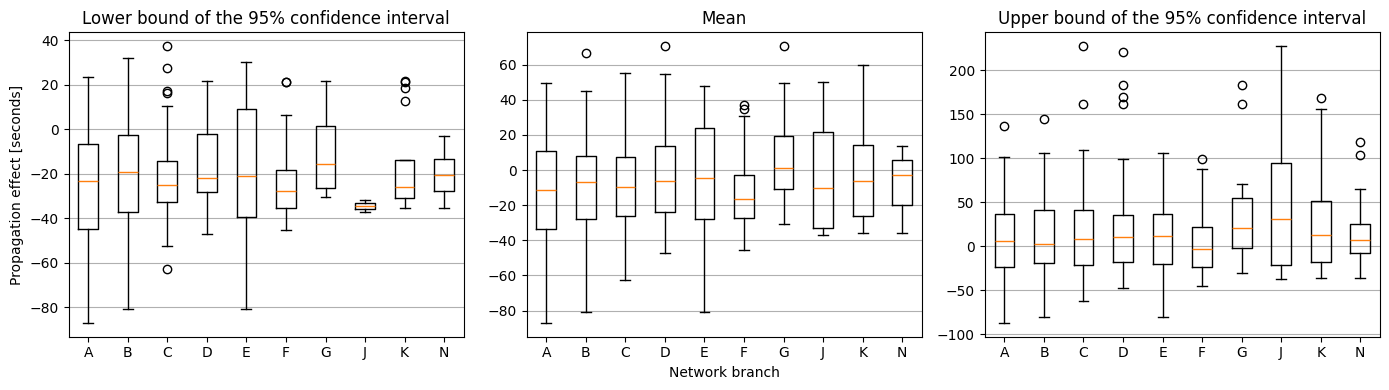

In [18]:
branches = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'J', 'K', 'N']
data_dict = {branch: [] for branch in branches}

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

for value_type, ax, title in zip(['low', 'mean', 'high'], (ax1, ax2, ax3), TITLES):
    for connection, avgs in connection_avgs.items():
        if filter_out_connections(connection):
            continue

        for branch in branches:
            if branch in connection[0] or branch in connection[1]:
                data_dict[branch].append(avgs[value_type])

    bplot = ax.boxplot(data_dict.values(),
                    tick_labels=branches)

    if ax == ax1:
        ax.set_ylabel('Propagation effect [seconds]')
    if ax == ax2:
        ax.set_xlabel('Network branch')
    ax.set_title(title)
    ax.grid(axis='y')

plt.tight_layout()

if FULLY_FILTERED:
    plt.savefig(r'Codebase figures\boxplot_branch_filtered.png', dpi=200)
else:
    plt.savefig(r'Codebase figures\boxplot_branch.png', dpi=200)


## Boxplot per hour per number of lines

In [19]:
lines_per_connection = [connection_line_pair for connection_line_pair, _ in delays.groupby(['previous_stop', 'stop', 'line_name'])]
lines_per_connection.sort()
lines_per_connection

connection_line_dict = {}
for entry in lines_per_connection:
    if entry[0] not in connection_line_dict:
        connection_line_dict[entry[0]] = {}
    if entry[1] not in connection_line_dict[entry[0]]:
        connection_line_dict[entry[0]][entry[1]] = []
    connection_line_dict[entry[0]][entry[1]].append(entry[2])

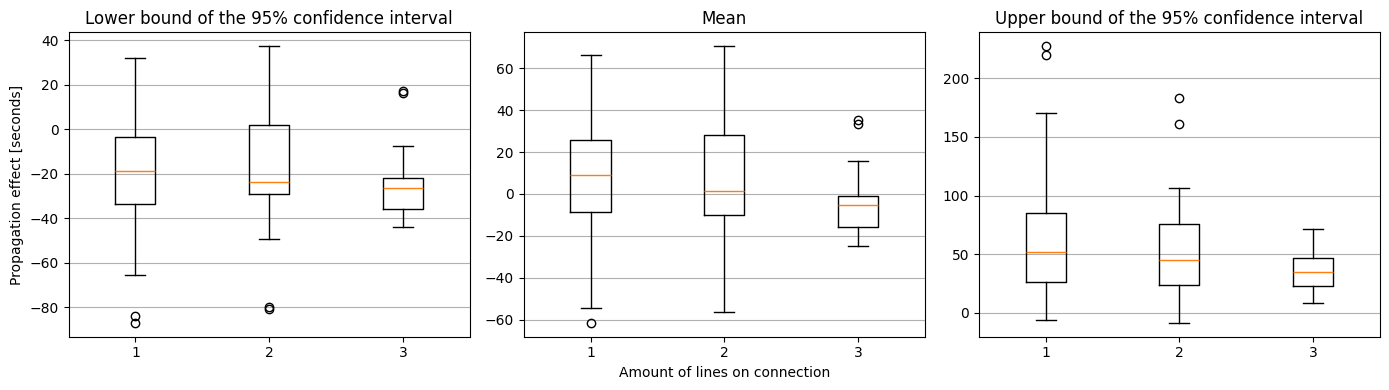

In [20]:
# Take into account that at some hours not all lines are travelling on a specific connection?

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

for value_type, ax, title in zip(['low', 'mean', 'high'], (ax1, ax2, ax3), TITLES):
    data_dict = {}
    for from_stop, from_stop_data in connection_line_dict.items():
        for to_stop, lines in from_stop_data.items():
            if filter_out_connections((from_stop, to_stop)):
                continue

            if len(lines) not in data_dict:
                data_dict[len(lines)] = []
            if (from_stop, to_stop) in connection_avgs:
                data_dict[len(lines)].append(connection_avgs[from_stop, to_stop][value_type])

    data_dict = dict(sorted(data_dict.items()))


    bplot = ax.boxplot(data_dict.values(),
                    tick_labels=data_dict.keys())
    if ax == ax1:
        ax.set_ylabel('Propagation effect [seconds]')
    if ax == ax2:
        ax.set_xlabel('Amount of lines on connection')
    ax.set_title(title)
    ax.grid(axis='y')

plt.tight_layout()

if FULLY_FILTERED:
    plt.savefig(r'Codebase figures\boxplot_number_of_lines_filtered.png', dpi=200)
else:
    plt.savefig(r'Codebase figures\boxplot_number_of_lines.png', dpi=200)

## Scatterplot avg time between trains

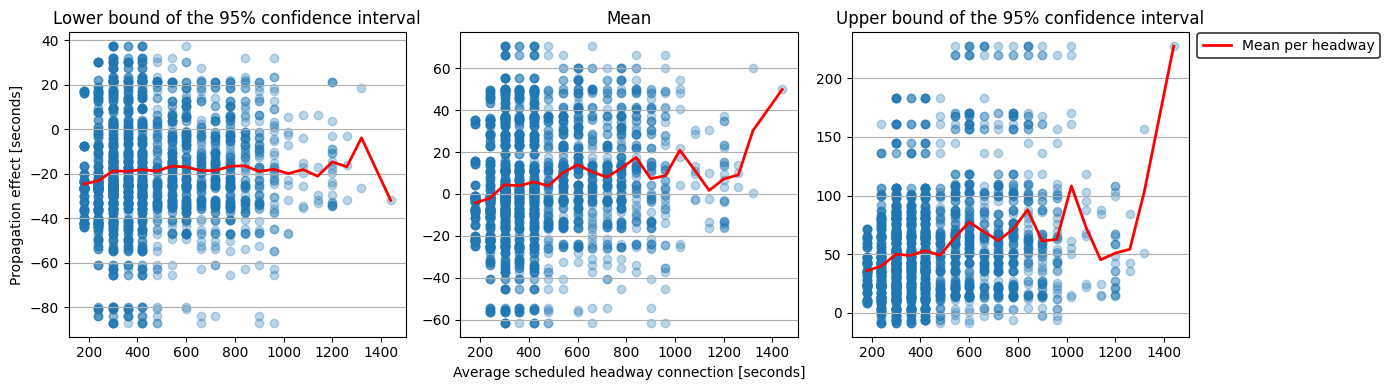

In [21]:
# Take into account that at some hours not all lines are travelling on a specific connection?

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

for value_type, ax, title in zip(['low', 'mean', 'high'], (ax1, ax2, ax3), TITLES):
    xs, ys = [], []
    for connection, connection_data in connection_avgs.items():
        if filter_out_connections(connection):
            continue

        time_diffs = inplace_functions[(inplace_functions['stop'] == connection[0]) & \
                                      (inplace_functions['direction'] == connection[1])]
        
        for _, entry in time_diffs.iterrows():
            xs.append(entry['avg_sched_time_diff'])  # in seconds
            ys.append(connection_data[value_type])
    scatter = ax.scatter(xs, ys, alpha=0.3)

    data_dict = {}
    for x, y in zip(xs, ys):
        if int(x) not in data_dict:
            data_dict[int(x)] = []
        data_dict[int(x)].append(y)
    data_dict = {key:data_dict[key] for key in sorted(data_dict.keys())}
    ax.plot(list(data_dict.keys()), [np.mean(value) for value in data_dict.values()], color='red', linewidth=2, label='Mean per headway')


    if ax == ax1:
        ax.set_ylabel('Propagation effect [seconds]')
    if ax == ax2:
        ax.set_xlabel('Average scheduled headway connection [seconds]')
    ax.set_title(title)
    ax.grid(axis='y')
    if ax == ax3:
        legend = ax.legend(bbox_to_anchor=(1.004, 1.02),  ncol=1)
        legend.get_frame().set_edgecolor('black')
        legend.get_frame().set_linewidth(1.2)

plt.tight_layout()

if FULLY_FILTERED:
    plt.savefig(r'Codebase figures\average_scheduled_headway_filtered.png', dpi=200)
else:
    plt.savefig(r'Codebase figures\average_scheduled_headwaylines.png', dpi=200)

## Boxplot to/from/in center

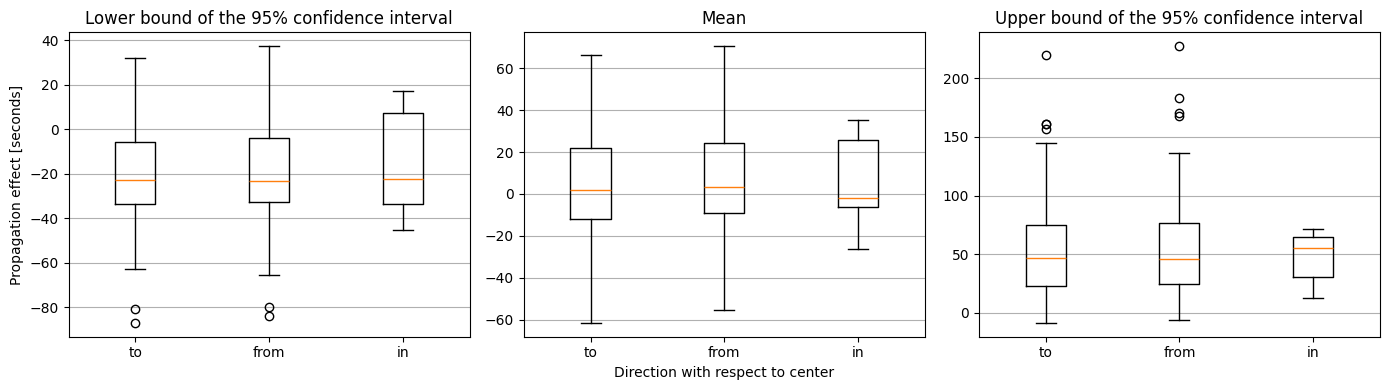

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

for value_type, ax, title in zip(['low', 'mean', 'high'], (ax1, ax2, ax3), TITLES):
    data_dict = {'to': [], 'from': [], 'in': []}

    for connection, avgs in connection_avgs.items():
        if filter_out_connections(connection):
            continue

        from_number = int(connection[0][-2:])
        to_number = int(connection[1][-2:])

        if from_number > to_number:
            data_dict['to'].append(avgs[value_type])
        elif from_number < to_number:
            data_dict['from'].append(avgs[value_type])
        else:  # from_number == to_number
            data_dict['in'].append(avgs[value_type])

    bplot = ax.boxplot(data_dict.values(),
                    tick_labels=data_dict.keys()) 

    if ax == ax1:
        ax.set_ylabel('Propagation effect [seconds]')
    if ax == ax2:
        ax.set_xlabel('Direction with respect to center')
    ax.set_title(title)
    ax.grid(axis='y')

plt.tight_layout()

if FULLY_FILTERED:
    plt.savefig(r'Codebase figures\boxplot_from_to_center_filtered.png', dpi=200)
else:
    plt.savefig(r'Codebase figures\boxplot_from_to_center.png', dpi=200)
